In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib 
from PIL import Image
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from captum.attr import visualization as viz
sys.path.append("../attacks/")
from utils import get_expl, torch_to_image, load_image,  convert_relu_to_softplus, heatmap_to_image
import mister_ed.loss_functions as lf
import mister_ed.utils.pytorch_utils as mister_ed_utils
from mister_ed.utils.pytorch_ssim import SSIM

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_mean = np.array([0.4914, 0.4822, 0.4465])
data_std = np.array([0.2023, 0.1994, 0.2010])

### MSE

In [4]:
mse_to_target_map = {"CURE": {"add": [], "add_recolor": [], "add_stadv": [], "add_stadv_recolor": []}, 
         "adv_train_RN50": {"add": [], "add_recolor": [], "add_stadv": [], "add_stadv_recolor": []}}

for method in ["CURE", "adv_train_RN50"]:
    for att in ["add", "add_recolor", "add_stadv", "add_stadv_recolor"]:
        for folder in os.listdir("../ad-hoc_results/"+method+"/"+att+"/"):
            with open("../ad-hoc_results/"+method+"/"+att+"/"+folder+"/output.log", "r") as f:
                lines = f.readlines()
                for l in lines[::-1]:
                    if l.startswith("expl loss:"):
                        mse_to_target_map[method][att].append(float(l.strip().split(" ")[-1]))
                        break

### LPIPS

In [5]:
lpips_to_original_image = {"CURE": {"add": [], "add_recolor": [], "add_stadv": [], "add_stadv_recolor": []}, 
         "adv_train_RN50": {"add": [], "add_recolor": [], "add_stadv": [], "add_stadv_recolor": []}}

for method in ["CURE", "adv_train_RN50"]:
    for att in ["add", "add_recolor", "add_stadv", "add_stadv_recolor"]:
        for folder in os.listdir("../ad-hoc_results/"+method+"/"+att+"/"):
            with open("../ad-hoc_results/"+method+"/"+att+"/"+folder+"/output.log", "r") as f:
                lines = f.readlines()
            lpips_to_original_image[method][att].append(float(lines[-2].strip().split(" ")[-1]))
                        

### viz

In [6]:
errors = {}
for k, v in mse_to_target_map.items():
    errors[k] = {k1: np.std(v1) for k1,v1 in v.items()}

In [7]:
lpips_errors = {}
for k, v in lpips_to_original_image.items():
    lpips_errors[k] = {k1: np.std(v1) for k1,v1 in v.items()}

Text(0, 0.5, '$LPIPS(x_{adv}, x)$')

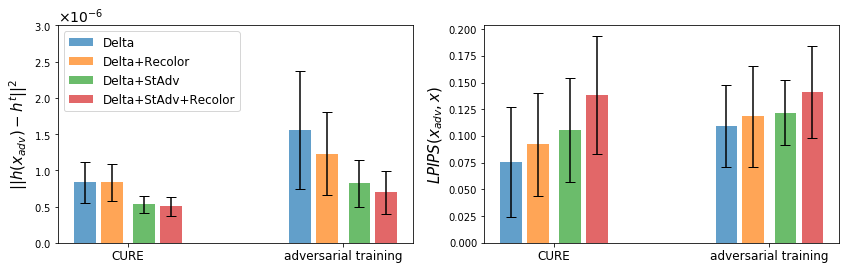

In [8]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))

x_s = np.array([1,2])
ax[0].bar(x_s - 0.2, 
           [np.mean(mse_to_target_map["CURE"]["add"]), 
            np.mean(mse_to_target_map["adv_train_RN50"]["add"])], 
            yerr=[errors["CURE"]["add"], errors["adv_train_RN50"]["add"]], width=0.1, label="Delta",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].bar(x_s - 0.075, 
           [np.mean(mse_to_target_map["CURE"]["add_recolor"]),
            np.mean(mse_to_target_map["adv_train_RN50"]["add_recolor"])], 
            yerr=[errors["CURE"]["add_recolor"], errors["adv_train_RN50"]["add_recolor"]], width=0.1, label="Delta+Recolor", 
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].bar(x_s + 0.075, 
           [np.mean(mse_to_target_map["CURE"]["add_stadv"]),
            np.mean(mse_to_target_map["adv_train_RN50"]["add_stadv"])], 
            yerr=[errors["CURE"]["add_stadv"], errors["adv_train_RN50"]["add_stadv"]], width=0.1, label="Delta+StAdv",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].bar(x_s + 0.2, 
           [np.mean(mse_to_target_map["CURE"]["add_stadv_recolor"]),
            np.mean(mse_to_target_map["adv_train_RN50"]["add_stadv_recolor"])], 
            yerr=[errors["CURE"]["add_stadv_recolor"], errors["adv_train_RN50"]["add_stadv_recolor"]], width=0.1, label="Delta+StAdv+Recolor",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].set_xticks(x_s)
ax[0].set_xticklabels(["CURE", "adversarial training"], fontsize=12)
ax[0].legend(fontsize=12)
ax[0].set_ylabel(r"$||h(x_{adv}) - h^t||^2$", fontsize=15)
ax[0].ticklabel_format(style='sci', axis='y',scilimits=(0,0), useMathText=True)
ax[0].yaxis.get_offset_text().set_fontsize(14)
ax[0].set_ylim(top=3e-6)

ax[1].bar(x_s - 0.2, 
           [np.mean(lpips_to_original_image["CURE"]["add"]), 
            np.mean(lpips_to_original_image["adv_train_RN50"]["add"])], 
            yerr=[lpips_errors["CURE"]["add"], lpips_errors["adv_train_RN50"]["add"]], width=0.1, label="add",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].bar(x_s - 0.075, 
           [np.mean(lpips_to_original_image["CURE"]["add_recolor"]),
            np.mean(lpips_to_original_image["adv_train_RN50"]["add_recolor"])],
            yerr=[lpips_errors["CURE"]["add_recolor"], lpips_errors["adv_train_RN50"]["add_recolor"]], width=0.1, label="add_recolor",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].bar(x_s + 0.075, 
           [np.mean(lpips_to_original_image["CURE"]["add_stadv"]),
            np.mean(lpips_to_original_image["adv_train_RN50"]["add_stadv"])],
            yerr=[lpips_errors["CURE"]["add_stadv"], lpips_errors["adv_train_RN50"]["add_stadv"]], width=0.1, label="add_stadv",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].bar(x_s + 0.2, 
           [np.mean(lpips_to_original_image["CURE"]["add_stadv_recolor"]),
            np.mean(lpips_to_original_image["adv_train_RN50"]["add_stadv_recolor"])],
            yerr=[lpips_errors["CURE"]["add_stadv_recolor"], lpips_errors["adv_train_RN50"]["add_stadv_recolor"]], width=0.1, label="add_stadv_recolor",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].set_xticks(x_s)
ax[1].set_xticklabels(["CURE", "adversarial training"], fontsize=12)
# ax[1].legend(fontsize=12)
# ax[1].set_ylim(bottom=0.25)
ax[1].set_ylabel(r"$LPIPS(x_{adv}, x)$", fontsize=15)
# plt.savefig("compare_attacks_mse_cifar.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);